In [1]:
import torch
import torch.nn as nn
import numpy as np
from sklearn import datasets
import os
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import imageio
import matplotlib.pyplot as plt
import scipy.misc
import scipy
from torch.utils.data import DataLoader, TensorDataset
from skimage.transform import resize
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from scipy import ndimage
from PIL import Image

In [2]:
#root_dir = '07012018/data'
# for f in os.listdir(root_dir):
  #  sobel_dir = 'right/'
   # image_read_train = imageio.imread(os.path.join(root_dir,f))
    #image_read_train = imageio.imread(im)
   # image_read = image_read_train[-150:]
   # resized_image_train = (resize(image_read, [66, 200]))
    # resized_image_train = resized_image_train.astype("float32")
   # resized_image_train /= 255.
   # print(os.path.join(sobel_dir,f))
   # imageio.imsave(os.path.join(sobel_dir,f),resized_image_train) 

In [3]:
x = []
y = []
counter = 0

#read data.txt
with open("DataSetV1/data.txt") as f:
    for line in f:
        x.append("DataSetV1/right/" + line.split()[0]) # Image frame name
        
        y.append(float(line.split()[1].split(',',1)[0]) * scipy.pi / 180) # Steering angle in radians (Normalization)
        counter += 1
        if counter == 30000: 
          break
# counting the no. of image frames.
train_Y = np.asarray(y)
print(train_Y.shape)
No_Imges=len(x)
TrainingData=int(len(x) * 0.8)
TestData=int(len(x) * 0.2)

train_X = x[:int(len(x) * 0.8)]
train_Y = np.asarray(y[:int(len(x) * 0.8)])
test_X = x[:int(len(x) * 0.2)]
test_Y = np.asarray(y[:int(len(x) * 0.2)])

print("Total =",No_Imges)
print("Training Data==",TrainingData)
print("Testing Data==",TestData)

(30000,)
Total = 30000
Training Data== 24000
Testing Data== 6000


In [4]:
# Resing Traning Images
train_X_Final= []
for i in range (TrainingData):
    image_read_train = np.array(imageio.imread(train_X[i]))
    train_X_Final.append(np.array(image_read_train))
    
train_X_Final=np.array(train_X_Final)
print(train_X_Final.shape)
train_X_Final = train_X_Final.reshape(TrainingData,3, 66, 200)
train_X_Final=torch.from_numpy(train_X_Final.astype(np.float32))
print(train_X_Final.shape)
train_Y=torch.from_numpy(train_Y.astype(np.float32))

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_6968\256380858.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image_read_train = np.array(imageio.imread(train_X[i]))


(24000, 66, 200, 3)
torch.Size([24000, 3, 66, 200])


In [5]:
# Resing Testing Images
test_X_Final= []
for i in range (TestData):
    image_read_test_X = np.array(imageio.imread(test_X[i]))
    test_X_Final.append(np.array(image_read_test_X))
    
test_X_Final=np.array(test_X_Final)
print(test_X_Final.shape)
test_X_Final = test_X_Final.reshape(TestData,3, 66, 200)
test_X_Final=torch.from_numpy(test_X_Final.astype(np.float32))
print(test_X_Final.shape)
test_Y=torch.from_numpy(test_Y.astype(np.float32))

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_6968\4003485609.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image_read_test_X = np.array(imageio.imread(test_X[i]))


(6000, 66, 200, 3)
torch.Size([6000, 3, 66, 200])


In [6]:
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1)
        self.pool  = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, stride=1)
        self.conv5 = nn.Conv2d(64, 32, kernel_size=3, stride=1)
        self.fc1   = nn.Linear(1216, 64)  # Adjust input size based on your data
        self.fc2   = nn.Linear(64, 10)
        self.fc3   = nn.Linear(10, 1)
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = torch.flatten(x, 1)
      #  print("x----=",x.shape)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        softmax = nn.Softmax(dim=1)
        x=softmax(x)
        x = self.fc3(x)
        return x
#print(model)

In [7]:
def client_update(client_model, optimizer, train_loader, epoch=10):
    model.train()
    criterion=nn.MSELoss()
    for e in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data, target
            optimizer.zero_grad()
            output = client_model(data)
            loss=criterion(output,target)
           # loss = F.nll_loss(output, target.long())
            loss.backward()
            optimizer.step()
             
    return loss.item()


In [8]:
def server_aggregate(global_model, client_models):
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
         
        global_dict[k] = torch.stack([client_models[i].state_dict()[k] for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

In [9]:
def test(global_model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        criterion=nn.MSELoss()
        for data, target in test_loader:
            data, target = data, target
            output = global_model(data)
            test_loss+=criterion(output,target)
    test_loss /= len(test_loader.dataset)
   
    return test_loss

In [10]:
num_clients = 100
num_selected = 25
num_rounds = 25
epochs = 10
batch_size = 250

# Training Data Set
dataset = TensorDataset(train_X_Final, train_Y)

# Test Data Set
Testdataset = TensorDataset(test_X_Final, test_Y)
test_loader = torch.utils.data.DataLoader(Testdataset, batch_size=250, shuffle=True)

# Determine the sizes of subsets for each client
subset_sizes = [len(dataset) // num_clients for _ in range(num_clients)]
# Split the dataset into equal-sized subsets
traindata_split = random_split(dataset, subset_sizes)
# Create DataLoader for each subset
train_loader = [DataLoader(subset, batch_size=batch_size, shuffle=True) for subset in traindata_split]

#subset_size = len(dataset) // num_clients

# Split the dataset into equal-sized subsets
#train_loader = []
#start_idx = 0
#for _ in range(num_clients):
#    subset = torch.utils.data.Subset(TRN_loader, range(start_idx, start_idx + subset_size))
#     train_loader.append(subset)
#    start_idx += subset_size
    


    

global_model = cnn()
client_models = [cnn() for _ in range(num_selected)]
for model in client_models:
    model.load_state_dict(global_model.state_dict())
opt = [torch.optim.SGD(model.parameters(), lr=0.01) for model in client_models]

# Runnining FL
train_losses = []
test_losses  = []
for r in range(num_rounds):
   
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]

    # client update
    loss = 0
    for i in range(num_selected):
        
        loss += client_update(client_models[i], opt[i], train_loader[client_idx[i]], epoch=epochs)
    
     # serer aggregate
    server_aggregate(global_model, client_models)
    test_loss = test(global_model, test_loader)
    train_losses.append(loss / num_selected)
    test_losses.append(test_loss)
    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g' % (loss / num_selected, test_loss))

C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([240])) that is different to the input size (torch.Size([240, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([250])) that is different to the input size (torch.Size([250, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0-th round
average train loss 0.189 | test loss 0.00016
1-th round
average train loss 0.167 | test loss 0.000148
2-th round
average train loss 0.151 | test loss 0.000147
3-th round
average train loss 0.174 | test loss 0.000149
4-th round
average train loss 0.19 | test loss 0.000147
5-th round
average train loss 0.18 | test loss 0.00015
6-th round
average train loss 0.148 | test loss 0.000147
7-th round
average train loss 0.16 | test loss 0.000146
8-th round
average train loss 0.176 | test loss 0.000149
9-th round
average train loss 0.165 | test loss 0.000148
10-th round
average train loss 0.182 | test loss 0.000148
11-th round
average train loss 0.186 | test loss 0.000149
12-th round
average train loss 0.179 | test loss 0.000147
13-th round
average train loss 0.171 | test loss 0.000146
14-th round
average train loss 0.166 | test loss 0.000147
15-th round
average train loss 0.176 | test loss 0.000147
16-th round
average train loss 0.166 | test loss 0.000146
17-th round
average train los

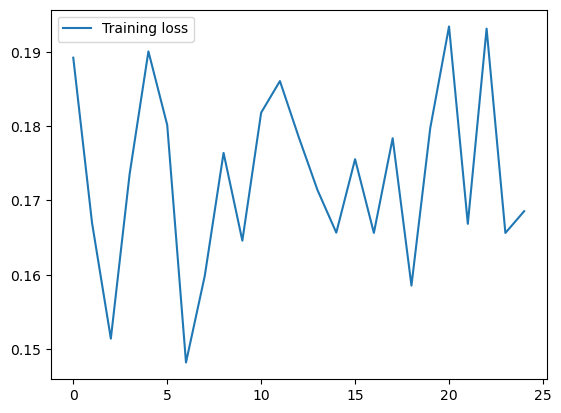

In [11]:
plt.plot(train_losses, label='Training loss')
plt.legend()
plt.show()

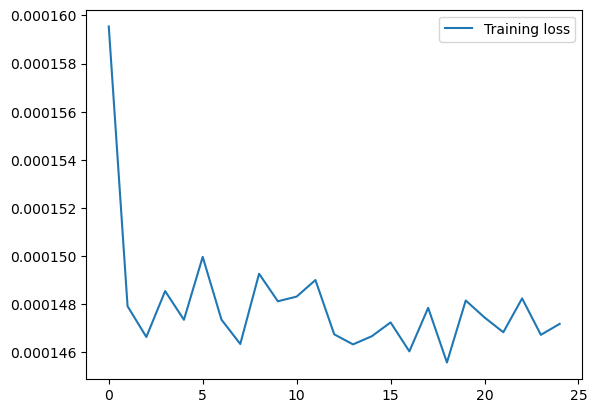

In [12]:
plt.plot(test_losses, label='Training loss')
plt.legend()
plt.show()

In [13]:
num_clients = 100
num_selected = 25
num_rounds = 100
epochs = 10
batch_size = 250

# Training Data Set
dataset = TensorDataset(train_X_Final, train_Y)

# Test Data Set
Testdataset = TensorDataset(test_X_Final, test_Y)
test_loader = torch.utils.data.DataLoader(Testdataset, batch_size=250, shuffle=True)

# Determine the sizes of subsets for each client
subset_sizes = [len(dataset) // num_clients for _ in range(num_clients)]
# Split the dataset into equal-sized subsets
traindata_split = random_split(dataset, subset_sizes)
# Create DataLoader for each subset
train_loader = [DataLoader(subset, batch_size=batch_size, shuffle=True) for subset in traindata_split]

#subset_size = len(dataset) // num_clients

# Split the dataset into equal-sized subsets
#train_loader = []
#start_idx = 0
#for _ in range(num_clients):
#    subset = torch.utils.data.Subset(TRN_loader, range(start_idx, start_idx + subset_size))
#     train_loader.append(subset)
#    start_idx += subset_size
    


    

global_model = cnn()
client_models = [cnn() for _ in range(num_selected)]
for model in client_models:
    model.load_state_dict(global_model.state_dict())
opt = [torch.optim.SGD(model.parameters(), lr=0.01) for model in client_models]

# Runnining FL
train_losses = []
test_losses  = []
for r in range(num_rounds):
   
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]

    # client update
    loss = 0
    for i in range(num_selected):
        
        loss += client_update(client_models[i], opt[i], train_loader[client_idx[i]], epoch=epochs)
    
     # serer aggregate
    server_aggregate(global_model, client_models)
    test_loss = test(global_model, test_loader)
    train_losses.append(loss / num_selected)
    test_losses.append(test_loss)
    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g' % (loss / num_selected, test_loss))

0-th round
average train loss 0.157 | test loss 0.000166
1-th round
average train loss 0.19 | test loss 0.000151
2-th round
average train loss 0.183 | test loss 0.000148
3-th round
average train loss 0.182 | test loss 0.000148
4-th round
average train loss 0.171 | test loss 0.000146
5-th round
average train loss 0.165 | test loss 0.000146
6-th round
average train loss 0.171 | test loss 0.000146
7-th round
average train loss 0.175 | test loss 0.000147
8-th round
average train loss 0.18 | test loss 0.000147
9-th round
average train loss 0.177 | test loss 0.000148
10-th round
average train loss 0.191 | test loss 0.000148
11-th round
average train loss 0.186 | test loss 0.000147
12-th round
average train loss 0.168 | test loss 0.000147
13-th round
average train loss 0.185 | test loss 0.000148
14-th round
average train loss 0.167 | test loss 0.000147
15-th round
average train loss 0.171 | test loss 0.000147
16-th round
average train loss 0.15 | test loss 0.000145
17-th round
average train l

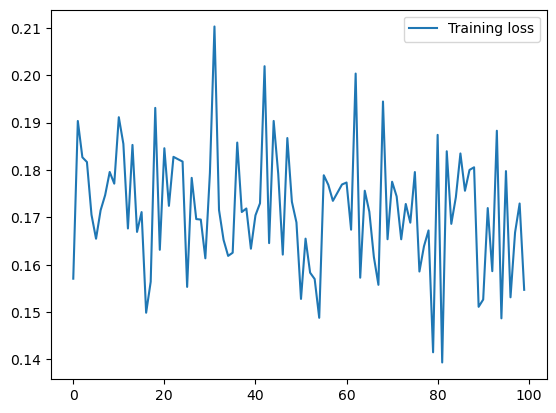

In [14]:
plt.plot(train_losses, label='Training loss')
plt.legend()
plt.show()

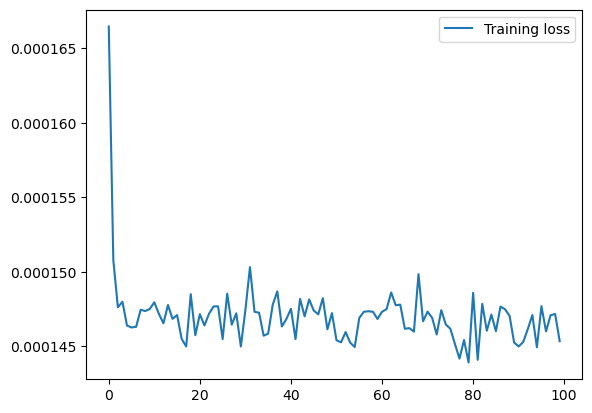

In [15]:
plt.plot(test_losses, label='Training loss')
plt.legend()
plt.show()

In [ ]:
num_clients = 100
num_selected = 25
num_rounds = 500
epochs = 10
batch_size = 250

# Training Data Set
dataset = TensorDataset(train_X_Final, train_Y)

# Test Data Set
Testdataset = TensorDataset(test_X_Final, test_Y)
test_loader = torch.utils.data.DataLoader(Testdataset, batch_size=250, shuffle=True)

# Determine the sizes of subsets for each client
subset_sizes = [len(dataset) // num_clients for _ in range(num_clients)]
# Split the dataset into equal-sized subsets
traindata_split = random_split(dataset, subset_sizes)
# Create DataLoader for each subset
train_loader = [DataLoader(subset, batch_size=batch_size, shuffle=True) for subset in traindata_split]

#subset_size = len(dataset) // num_clients

# Split the dataset into equal-sized subsets
#train_loader = []
#start_idx = 0
#for _ in range(num_clients):
#    subset = torch.utils.data.Subset(TRN_loader, range(start_idx, start_idx + subset_size))
#     train_loader.append(subset)
#    start_idx += subset_size
    


    

global_model = cnn()
client_models = [cnn() for _ in range(num_selected)]
for model in client_models:
    model.load_state_dict(global_model.state_dict())
opt = [torch.optim.SGD(model.parameters(), lr=0.01) for model in client_models]

# Runnining FL
train_losses = []
test_losses  = []
for r in range(num_rounds):
   
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]

    # client update
    loss = 0
    for i in range(num_selected):
        
        loss += client_update(client_models[i], opt[i], train_loader[client_idx[i]], epoch=epochs)
    
     # serer aggregate
    server_aggregate(global_model, client_models)
    test_loss = test(global_model, test_loader)
    train_losses.append(loss / num_selected)
    test_losses.append(test_loss)
    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g' % (loss / num_selected, test_loss))

0-th round
average train loss 0.199 | test loss 0.000156
1-th round
average train loss 0.176 | test loss 0.000147


In [ ]:
plt.plot(train_losses, label='Training loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(test_losses, label='Training loss')
plt.legend()
plt.show()

In [ ]:
from jupyter_core.paths import jupyter_config_dir
print(jupyter_config_dir())